# Checkpoint 7

In [752]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import time
from scipy import integrate
import scipy
import scipy.stats

In [753]:
from iminuit import Minuit

In [754]:
DATA = np.loadtxt('datafile-expresonance.txt')

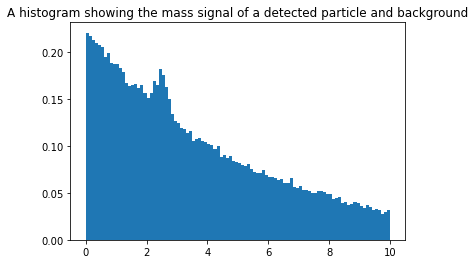

In [757]:
#print histogram of decay times including background and signal, in 100 bins
#normalize the histogram with density=True
N, bins, _ = plt.hist(DATA,bins=100,density=True)
plt.title('A histogram showing the mass signal of a detected particle and background')
plt.show()

## Part 1 - Exponential background

- Fit the given data with an exponential-background model $\begin{equation} F(x) = e^{-x/A} \end{equation}$ to determine the best fit parameters for F, the fraction of the signal, A, the exponential decay constant and M, the mass of the particle in the signal

In [657]:
def func(m, A, M, F):
    
    """A function which returns a composite function of a gaussian signal and an exponential background"""
    
    #x limits
    xmin = 0
    xmax = 10
    
    #width of gauss signal
    sigma = 0.2

    #background given as normalized exponential decay
    BKG = np.exp(-m/A) * 1/(A*(np.exp(-xmin/A) -  np.exp(-xmax/A)))
    
    #signal given as normalised gaussian with mean 'gauss_mu' and standard deviation 'sigma'
    GAUSS = 1/(np.sqrt(2*np.pi)*sigma) * np.exp(-0.5*(m-M)**2/sigma**2)
    
    #returns composite function fraction of background + (1-fraction) of signal
    return F*BKG + (1-F)*GAUSS

In [658]:
def get_NLL(A, M, F): 
    
    """A function which generates the negative log likelihood of the composite function"""
    
    #generate the mean, mu
    mu = func(DATA, A, M, F)
    
    #make sure that if mean is less than 10-4, return 10-4, so that there are no negative errors
    mu[mu<1e-4] = 1e-4
    
    #generate the log using the calculated mean
    LL = np.log(mu)
    
    #negative log likely hood is the negative of the sum over all log pmfs
    NLL = -np.sum(LL)
    
    return NLL

In [659]:
#set error of NLL to 0.5
get_NLL.errordef = 0.5 

#give guesses for lifetime, gaussian mean and fraction
m_exp = Minuit(get_NLL, A = 4, M = 2, F = 0.9)

In [660]:
#get minimizer
m_exp.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.146e+05                  │              Nfcn = 103              │
│ EDM = 1.46e-06 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │   5.008   │   0.031   │            │            │         │         │       │
│ 1 │ M    │   2.499   │   0.015   │            │            │         │         │       │
│ 2 │ F    │  0.9796   │  0.0012   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────────────────┐
│   │         A         M         F │
├───┼───────────────────────────────┤
│ A │  0.000945  -1.7e-05 -4.01e-06 │
│ M │  -1.7e-05  0.000212     7e-07 │
│ F │ -4.01e-06     7e-07  1.33e-06 │
└───┴───────────────────────────────┘

In [750]:
#print the statistical error of the mass given by minuit
Estat_exp = m_exp.errors[1]
Estat_exp

0.014569836952350233

In [663]:
#generate function with parametrs given by minuit
t = np.linspace(0,10,1000)
y_exp = func(t, 5.008, 2.499, 0.9796)

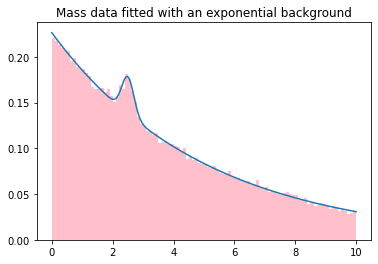

In [664]:
#fit optimized function to data
plt.plot(t,y_exp)
plt.hist(DATA,bins=100,color='pink',density=True)
plt.title('Mass data fitted with an exponential background');

The parameters with central value V and their statistical errors are given by the following: **$V \pm E_{stat}$:** $\newline$
**A = $5.008 \pm 0.031$**

**M = $2.499 \pm 0.015$**

**F = $0.9796 \pm 0.0012$**


Fitting the background to an exponential gives us a mass value of $2.499 \pm 0.015$, where $ \pm 0.015$ is the statistical error. Plotting the optimized function on the real data shows the agreement between the two, suggesting that the exponential model of the background is accurate. We can also see this accuracy from how close the given mass, 2.499, is to the true value, 2.5.

## Part 2 - Polynomial background

- Determine a systematic error on the mean of the Gaussian (M) by the “shift” method by fitting the given data with an polynomial-background model $\begin{equation} F(x) = a + bx + cx^2 \end{equation}$. 
- Determine the best fit parameters for F, the fraction of the signal, b and c the second order polynomial constants amd again M, the mass of the particle in the signal.

In [666]:
def func2(m, b, c, M, F):
    
    """A function which returns a composite function of a gaussian signal and an second order polynomial background"""
    
    #x limits
    xmin = 0
    xmax = 10
    
    #width of gauss signal
    sigma = 0.2

    #background given as normalized 2nd degree polynomial
    a=1
    BKG = (a + b*m + c*m**2)/(xmax + b*xmax**2/2 + c*xmax**3/3)#
    
    #signal given as normalised gaussian with mean 'gauss_mu' and standard deviation 'sigma'
    GAUSS = 1/(np.sqrt(2*np.pi)*sigma) * np.exp(-0.5*(m-M)**2/sigma**2)
    
    #returns composite function fraction of background + (1-fraction) of signal
    return F*BKG + (1-F)*GAUSS

In [667]:
def get_NLL2(b, c, M, F): 
    
    """A function which generates the negative log likelihood of the composite function"""

    #generate the mean, mu
    mu = func2(DATA, b, c, M, F)
    
    #make sure that if mean is less than 10-4, return 10-4, so that there are no negative errors
    mu[mu<1e-4] = 1e-4
    
    #generate the log using the calculated mean
    LL = np.log(mu)
    
    #negative log likely hood is the negative of the sum over all log pmfs
    NLL = -np.sum(LL)
    
    return NLL

In [668]:
#set error of NLL to 0.5
get_NLL2.errordef = 0.5

#give guesses for lifetime, gaussian mean and fraction
m_poly = Minuit(get_NLL2, b = -0.016, c = 0.007, M = 2.5, F = 0.98)

In [669]:
#get minimizer
m_poly.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.146e+05                  │              Nfcn = 132              │
│ EDM = 1.45e-06 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ b    │  -0.1578  │  0.0011   │            │            │         │         │       │
│ 1 │ c    │  7.30e-3  │  0.12e-3  │            │            │         │         │       │
│ 2 │ M    │   2.494   │   0.016   │            │            │         │         │       │
│ 3 │ F    │  0.9820   │  0.0012   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────────────────────┐
│   │         b         c         M         F │
├───┼─────────────────────────────────────────┤
│ b │  1.14e-06 -1.23e-07 -5.72e-07 -3.44e-08 │
│ c │ -1.23e-07   1.4e-08  5.72e-08 -6.66e-10 │
│ M │ -5.72e-07  5.72e-08  0.000244  7.04e-07 │
│ F │ -3.44e-08 -6.66e-10  7.04e-07  1.35e-06 │
└───┴─────────────────────────────────────────┘

In [670]:
#generate function with parameters given by minuit
y_poly = func2(t, -0.1578, 7.30e-3, 2.494, 0.9820)

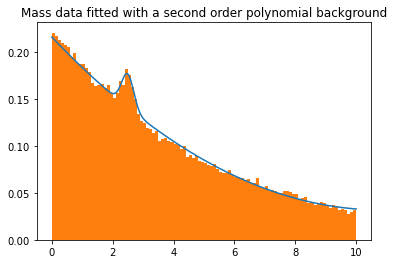

In [671]:
plt.plot(t,y_poly)
plt.hist(DATA,bins=100,density=True)
plt.title('Mass data fitted with a second order polynomial background');

The parameters with central value V and their statistical errors are given by the following: **$V \pm E_{stat}$:** $\newline$
**b = $-0.1578 \pm 0.0011$**

**c = $7.30\times10^{-3} \pm 0.12\times10^{-3}$**

**M = $2.494 \pm 0.016$**

**F = $0.9820 \pm 0.0012$**


Fitting the background to a second order polynomial gives us a mass value of $2.494 \pm 0.016$ where $\pm 0.016$ is the statistical error. This is relatively close to the true mass value (2.5) but not as close as the exponential fit of the model (2.499) which is expected as we can see the exponential model fits almost perfectly and the polynomial is a less accurate approximation.

### Systematic Errors

#### Systematic error: Method 1 

Shift is the difference in the mean generated by the fit on the exponential background and the mean generated by the fit of the
polynomial background, as the systematic error takes into account the uncertainty of experiment (e.g we do not know what the
background looks like). We run the minimization for M equal to the central value plus the statistical error, and then for M equal to the central value minus the statistical error, and take the average. The systematic error is then the difference between this value of $M_{\text{poly}}$ and the value given by the exponential model $M_{\text{exp}}$.

In [672]:
#shift method: taking M to be V + E_stat, M = 2.494 + 0.016
m1 = Minuit(get_NLL2, b = -0.016, c = 0.007, M = (2.494 + 0.016), F = 0.98)

In [673]:
m1.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.146e+05                  │              Nfcn = 131              │
│ EDM = 1.1e-06 (Goal: 0.0001)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ b    │  -0.1578  │  0.0011   │            │            │         │         │       │
│ 1 │ c    │  7.30e-3  │  0.12e-3  │            │            │         │         │       │
│ 2 │ M    │   2.494   │   0.016   │            │            │         │         │       │
│ 3 │ F    │  0.9820   │  0.0012   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────────────────────┐
│   │         b         c         M         F │
├───┼─────────────────────────────────────────┤
│ b │  1.14e-06 -1.23e-07 -5.72e-07 -3.44e-08 │
│ c │ -1.23e-07   1.4e-08  5.72e-08 -6.66e-10 │
│ M │ -5.72e-07  5.72e-08  0.000244  7.03e-07 │
│ F │ -3.44e-08 -6.66e-10  7.03e-07  1.35e-06 │
└───┴─────────────────────────────────────────┘

In [677]:
#shift method: taking M to be V - E_stat, M = 2.494 - 0.016
m2 = Minuit(get_NLL2, b = -0.016, c = 0.007, M = (2.494 - 0.016), F = 0.98)

In [678]:
m2.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.146e+05                  │              Nfcn = 100              │
│ EDM = 1.08e-07 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ b    │  -0.1578  │  0.0014   │            │            │         │         │       │
│ 1 │ c    │  7.30e-3  │  0.15e-3  │            │            │         │         │       │
│ 2 │ M    │   2.494   │   0.016   │            │            │         │         │       │
│ 3 │ F    │  0.9820   │  0.0012   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────────────────────┐
│   │         b         c         M         F │
├───┼─────────────────────────────────────────┤
│ b │  1.89e-06 -2.07e-07 -1.03e-06 -3.44e-08 │
│ c │ -2.07e-07  2.33e-08  1.08e-07 -7.78e-10 │
│ M │ -1.03e-06  1.08e-07  0.000246  6.57e-07 │
│ F │ -3.44e-08 -7.78e-10  6.57e-07  1.36e-06 │
└───┴─────────────────────────────────────────┘

In [758]:
#shift is difference between central values generated by the two models
#calculate the shift for M + Err and M - Err
shift1 = m_exp.values[1]-m1.values[2]
shift2 = m_exp.values[1]-m2.values[2]

In [737]:
#taking systematic error as the average of the two shifts
Esyst_poly = (shift1+shift2)/2
#getting statistical error from minuit optimizer
Estat_poly = m_poly.errors[2]

print('E_syst =',Esyst_poly)
print('E_stat =',Estat_poly)

E_syst = 0.004226683247484209
E_stat = 0.015625812492444626


We may have imperfect knowledge of our background model, so we have systematic error due to this, as we don't know if the background takes an exponential or polynomial form. We therefore calculate the systematic error by looking at the shift in mass means due to the modelling of different backgrounds. We compare the polynomial background to the exponential background and observe the effect this has on the mass value. Since we cannot be sure, we must account for some systematic error due to the modelling choice. Systematic error in mass M due to background is **$E_{\text{bgd}} = E_{\text{syst}} = \pm 0.0042$**

The value of M with statistical and systematic errors is given by $\text{Value} \pm E_{stat} \pm E_{syst}:$

$\text{M}_{\text{poly}} = 2.494 \pm 0.0156 \pm 0.00422 \newline$

Using $E_{tot} = \sqrt{( E_{stat}^2 + E_{syst}^2 )}$, we calculate total error by adding in quadrature

In [739]:
Etot_poly = np.sqrt(Estat_poly**2 + Esyst_poly**2)
print('E_tot =',Etot_poly)

E_tot = 0.01618736752296686


The value of M with total errors is given by $\text{Value} \pm E_{tot}:$

$\text{M}_{\text{poly}} = 2.494 \pm 0.016$

#### Systematic error: Method 2

In [685]:
from scipy import stats

In [691]:
count = 0
shift_poly = []
#create a while loop to run 100 iterations
while count<100:
    
    #Pick random values of G_rand from a Gaussian distribution centred on M with width of error E_stat
    G_rand = np.random.normal(loc=m_poly.values[2], scale=m_poly.errors[2])
    
    #Re-run the fit with each G_rand and measure the set of shifts it induces on the best fit physics parameters. 
    m_rand_poly = Minuit(get_NLL2, b = -0.016, c = 0.007, M = G_rand, F = 0.98)
    m_rand_poly.migrad()
    
    #Append these Shift values to a list
    shift_poly.append(m_exp.values[1]-m_rand_poly.values[2])
    
    count +=1

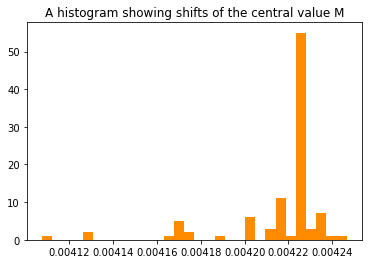

In [762]:
plt.hist(shift_poly,bins=30,color='darkorange');
plt.title('A histogram showing shifts of the central value M')
plt.show()

In [693]:
#fitting histogram to gaussian
mu,std = stats.norm.fit(shift_poly, loc=0, scale=1) 
print('mean and standard deviation are', mu, 'and', std,'respectively')

mean and standard deviation are 0.004215825408882417 and 2.3401271785363023e-05 respectively


Method 2 generates a (skewered) Gaussian, centered on the systematic error. Method 2 is a more accurate version of method 1, using random values taken from a gaussian distribution of mean value and statistical error generated by the minuit minimization. This generates a narrow gaussian, when a narrow gaussian is generated instead of a wide gaussian, the systematic error is taken to be the mean, which we can see here agrees with Method 1. Doing many iterations cancels out any large errors due to an error in minimization (if G_random happens to be at the extremeties) and so gives a more accurate value of the systematic error. The value of the systematic error is given as $\text{E}_{\text{syst}} = \pm 0.0042$.

## Part 3 - Linear background

In [700]:
def func3(m, b, M, F):
    
    """A function which returns a composite function of a gaussian signal and a linear background"""
   
    #x limits
    xmin = 0
    xmax = 10
    
    #width of gauss signal
    sigma = 0.2

    #background given as normalized straight line
    a=1
    BKG = (a + b*m) / (xmax + b*xmax**2/2)
    
    #signal given as normalised gaussian with mean 'gauss_mu' and standard deviation 'sigma'
    GAUSS = 1/(np.sqrt(2*np.pi)*sigma) * np.exp(-0.5*(m-M)**2/sigma**2)
    
    #returns composite function fraction of background + (1-fraction) of signal
    return F*BKG + (1-F)*GAUSS

In [701]:
def get_NLL3(b, M, F): 
    
    """A function which generates the negative log likelihood of the composite function"""

    #generate the mean, mu
    mu = func3(DATA, b, M, F)
    
    #make sure that if mean is less than 10-4, return 10-4, so that there are no negative errors
    mu[mu<1e-4] = 1e-4
    
    #generate the log using the calculated mean
    LL = np.log(mu)
    
    #negative log likely hood is the negative of the sum over all log pmfs
    NLL = -np.sum(LL)
    
    return NLL

In [702]:
#set error of NLL to 0.5
get_NLL3.errordef = 0.5
#give guesses for lifetime, gaussian mean and fraction
m_lin = Minuit(get_NLL3, b = -0.09, M = 2.5, F = 0.98)

In [703]:
m_lin.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.155e+05                  │              Nfcn = 50               │
│ EDM = 3.95e-06 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ b    │ -90.41e-3 │  0.22e-3  │            │            │         │         │       │
│ 1 │ M    │   2.465   │   0.015   │            │            │         │         │       │
│ 2 │ F    │  0.9801   │  0.0012   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────────────────┐
│   │         b         M         F │
├───┼───────────────────────────────┤
│ b │  4.97e-08 -5.11e-08 -3.36e-08 │
│ M │ -5.11e-08  0.000229  6.04e-07 │
│ F │ -3.36e-08  6.04e-07  1.35e-06 │
└───┴───────────────────────────────┘

In [704]:
#generate optimized function using minuits parameters
y_lin = func3(t, -90.41e-3, 2.465, 0.9801)

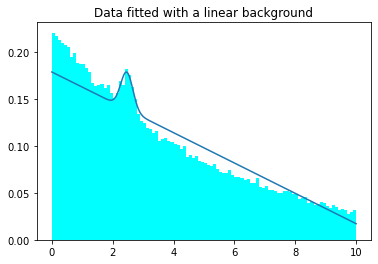

In [705]:
plt.plot(t,y_lin)
plt.hist(DATA,bins=100,density=True,color='cyan')
plt.title('Data fitted with a linear background');

Fitting the background to a straight line gives us a mass value of $2.456 \pm 0.015$, where $\pm 0.015$ is the statistical error. We expect the mean of the mass value (2.456) to be off from the expected value (2.5) as we can clearly see this approximation does not fit the histogram of data very well. 

### Systematic errors

#### Systematic error: Method 1

In [706]:
#taking M to be 2.456 + 0.015
m_lin1 = Minuit(get_NLL3, b = -0.09, M = (2.456 + 0.015), F = 0.98)
m_lin1.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.155e+05                  │              Nfcn = 58               │
│ EDM = 1.1e-07 (Goal: 0.0001)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ b    │ -90.40e-3 │  0.22e-3  │            │            │         │         │       │
│ 1 │ M    │   2.465   │   0.015   │            │            │         │         │       │
│ 2 │ F    │  0.9801   │  0.0012   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────────────────┐
│   │         b         M         F │
├───┼───────────────────────────────┤
│ b │  4.97e-08 -5.11e-08 -3.36e-08 │
│ M │ -5.11e-08  0.000229  6.03e-07 │
│ F │ -3.36e-08  6.03e-07  1.35e-06 │
└───┴───────────────────────────────┘

In [707]:
#taking M to be 2.456 - 0.015
m_lin2 = Minuit(get_NLL3, b = -0.09, M = (2.456 - 0.015), F = 0.98)
m_lin2.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.155e+05                  │              Nfcn = 56               │
│ EDM = 7.55e-07 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ b    │ -90.40e-3 │  0.22e-3  │            │            │         │         │       │
│ 1 │ M    │   2.465   │   0.015   │            │            │         │         │       │
│ 2 │ F    │  0.9801   │  0.0012   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────────────────┐
│   │         b         M         F │
├───┼───────────────────────────────┤
│ b │  4.97e-08 -5.11e-08 -3.36e-08 │
│ M │ -5.11e-08  0.000229  6.03e-07 │
│ F │ -3.36e-08  6.03e-07  1.35e-06 │
└───┴───────────────────────────────┘

In [708]:
#calculate shift of central value from exponential to linear
shift_lin1 = m_exp.values[1]-m_lin1.values[1]
shift_lin2 = m_exp.values[1]-m_lin2.values[1]

In [710]:
#get average of + and - shifts
print((shift_lin1+shift_lin2)/2)

0.03315005887905342


The systematic error given by the linear fit is $\text{E}_{\text{syst}} = \pm \text{0.033}$. This is taken from the shift in the mass mean M, by comparing M from the exponential background fit and M from the linear background fit. We expect the systematic error to be much larger than that of the polynomial as it clearly does not fit as well.

#### Systematic error: Method 2

In [716]:
count = 0
shift_lin = []
while count<100:
    
    #Pick random values of Gr from a Gaussian distribution centred on G with width EG
    G_rand_lin = np.random.normal(loc=m_lin.values[1], scale=m_lin.errors[1])
    
    #Re-run the fit with each G_rand and measure the set of shifts it induces on the best fit physics parameters. 
    m_rand_lin = Minuit(get_NLL3, b = -0.09, M = G_rand_lin, F = 0.98)
    m_rand_lin.migrad()
    
    #append to shift list
    shift_lin.append(m_exp.values[1]-m_rand_lin.values[1])
    count +=1

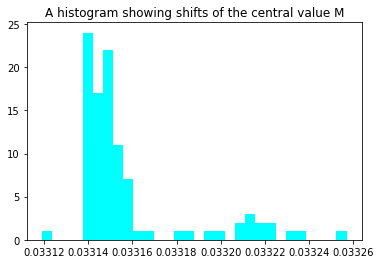

In [764]:
plt.hist(shift_lin,bins=30,color='cyan');
plt.title('A histogram showing shifts of the central value M')
plt.show()

In [718]:
#fitting histogram to gaussian
mu,std = stats.norm.fit(shift_lin, loc=0, scale=1) 
print('mean and standard deviation are', mu, 'and', std,'respectively')

mean and standard deviation are 0.03315777176277114 and 2.659040824991017e-05 respectively


In [742]:
#statistical error
Estat_lin = m_lin.errors[1]

#systematic error
Esyst_lin = (shift_lin1+shift_lin2)/2

print('E_syst =',Esyst_lin)
print('E_stat =',Estat_lin)

E_syst = 0.03315005887905342
E_stat = 0.015138099766547652


Again method 2 generates a narrow gaussian, where the mean of this gaussian is taken to be the systematic error, which we can see here again agrees with Method 1. The systematic error given by the linear fit is $\text{E}_{\text{syst}} = \pm \text{0.033}$ and the statistical error $\pm 0.015$. 

The value of M with statistical and systematic errors is given by $\text{Value} \pm E_{stat} \pm E_{syst}:$

$\text{M}_{\text{lin}} = 2.456 \pm 0.015 \pm 0.033 \newline$

Using $E_{tot} = \sqrt{( E_{stat}^2 + E_{syst}^2 )}$, we calculate total error by adding in quadrature

In [743]:
Etot_lin = np.sqrt(Estat_lin**2 + Esyst_lin**2)
print('E_tot =',Etot_lin)

E_tot = 0.0364429481275412


The value of M with total errors is given by $\text{Value} \pm E_{tot}:$

$\text{M}_{\text{lin}} = 2.456 \pm 0.036$

In [766]:
#get statistical errors of each model
print('Statistical errors:',Estat_poly,Estat_lin,Estat_exp)

#get systematic errors of each model
print('Systematic errors:',Esyst_poly,Esyst_lin)

Statistical errors: 0.015625812492444626 0.015138099766547652 0.014569836952350233
Systematic errors: 0.004226683247484209 0.03315005887905342


As expected, the best most accurate mean was given by the exponential model (2.499), then the second degree polynomial (2.494) and lastly the linear model (2.456), where the true value was 2.5. The statistical errors are very similar for all three models as this is due to the minimization, for which the same method has been used each time. The systematic error is larger for linear than the polynomial, as the linear model differentiates the most from the true fit. This (incorrect) assumption of the background results in a skew in the mean of the signal, and thus generates a larger systematic error as the nature of the background's shape is unknown.
